In [1]:
import io
import math

import torch
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import datasets, train, models, utils

import pytorch_lightning as pl

from compressai.zoo import bmshj2018_hyperprior

In [2]:
def pillow_encode(img, fmt='jpeg', quality=10):
    tmp = io.BytesIO()
    img.save(tmp, format=fmt, quality=quality)
    tmp.seek(0)
    filesize = tmp.getbuffer().nbytes
    bpp = filesize * float(8) / (img.size[0] * img.size[1])
    rec = Image.open(tmp)
    return rec, bpp

In [3]:
def find_closest_bpp(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        if bpp > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp
    
def mse(a, b):
    a = np.asarray(a).astype(np.float32)
    b = np.asarray(b).astype(np.float32)
    return np.mean(np.square(a - b))

def psnr(a, b, max_value=255):
        return psnr_from_mse(mse(a, b, max_value))
    
def psnr_from_mse(mse, max_value=255):
        return 20 * math.log10(max_value) - 10. * math.log10(mse)

In [4]:
def compare_with_classical(rec_net, original_image, target_bpp):
    rec_jpeg, bpp_jpeg = find_closest_bpp(target_bpp, original_image, fmt="jpeg")
    rec_webp, bpp_webp = find_closest_bpp(target_bpp, original_image, fmt='webp')

    fig, axes = plt.subplots(2, 2, figsize=(18, 15))
    for ax in axes.ravel():
        ax.axis('off')

    fig.title = 'yolo'
    axes[0][0].imshow(original_image)
    axes[0][0].title.set_text('Original')
    axes[0][1].imshow(rec_net)
    axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp, {mse(rec_net, original_image):.2f} mse')
    axes[1][0].imshow(rec_jpeg)
    axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp, {mse(rec_jpeg, original_image):.2f} mse')
    axes[1][1].imshow(rec_webp)
    axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp, {mse(rec_webp, original_image):.2f} mse')

    plt.show()

In [5]:
def get_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

In [6]:
def run_pretrained_model(image, model, quality, verbose=True):
    device = 'cpu'

    net = model(quality=quality, pretrained=True).eval().to(device)

    if type(image) == torch.Tensor:
        x = image
    else:
        x = transforms.ToTensor()(image).unsqueeze(0).to(device)

    with torch.no_grad():
        out_net = net.forward(x)
    
    out_net['x_hat'].clamp_(0, 1)

    if type(image) == torch.Tensor:
        rec_net = out_net['x_hat'].squeeze().cpu()
    else:
        rec_net = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())
    
    if verbose:
        print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

    return get_bpp(out_net), rec_net

In [7]:
def mse_across_tasks(batch, model):
    """
    We want to return an list of mse and bpp values for each task
    """
    
    ans = {key: {"mse": list(), "bpp": list()} for key in batch.keys()}


    # for all tasks
    for task, image_tensors in batch.items():
        # for all bpp values
        
        if model in ("JPEG", "WEBP"):
            for bpp in (0.2, 0.5, 0.8, 1):        

                batch_bpps = []
                batch_mses = []

                # for all images of the task in a batch
                for image_tensor in image_tensors:

                    image = transforms.ToPILImage()(image_tensor)

                    reconstruction, bpp = find_closest_bpp(bpp, image, fmt=model.lower())

                    batch_mses.append(mse(reconstruction, image))
                    batch_bpps.append(bpp)
                    
                ans[task]["bpp"].append(np.mean(batch_bpps))
                ans[task]["mse"].append(np.mean(batch_mses))

        elif model == "pretr":
            for quality in (1, 2, 3, 4, 5):
                
                if task == "depth_euclidean":
                    input_data = (image_tensors/image_tensors.max()).repeat(1, 3, 1, 1)
                else:
                    input_data = image_tensors

                bpp, reconstructions = run_pretrained_model(input_data, bmshj2018_hyperprior, quality, False)
                
                ans[task]["bpp"].append(bpp)
                ans[task]["mse"].append(mse(reconstructions, input_data))
        else:
            raise NotImplementedError()

    mean_bpp = np.mean(list(np.array(ans[task]["bpp"]) for task in ans.keys()), axis=0)
    mean_mse = np.mean(list(np.array(ans[task]["mse"]) for task in ans.keys()), axis=0)
    
    return ans, (mean_bpp, mean_mse)


In [46]:
pl.seed_everything(21)

TASKS = ["rgb", "depth_euclidean", "normal"]
DATASET = "clevr"
BATCH_SIZE = 64
default_collate = datasets.transforms.make_collate_fn(TASKS)

_, dataloader = train.get_dataloader(
    dataset_name=DATASET,
    batch_size=BATCH_SIZE,
    num_workers=0,
    tasks=TASKS,
    is_train=True,
    collate=default_collate,
)

batch = next(iter(dataloader))

TASK_CHANNELS = {
    "disjoint": range(0, 301, 100), 
    "shared": range(0, 301, 75)
}

NUM_PIXELS = 256 * 256

Global seed set to 21


---

### Compute MSE and BPP for JPEG

In [261]:
jpeg_ans, (jpeg_bpps, jpeg_mse) = mse_across_tasks(batch, model="JPEG")

---

### Compute MSE and BPP for Pretrained Scale Hyperprior

In [262]:
pretr_ans, (pretr_bpps, pretr_mse) = mse_across_tasks(batch, model="pretr")

# Rate-Distortion plots

In [263]:
def plot_averaged_rate_distortion_curves(data: dict, per_model: True, plot_title: str = "Rate-Distortion Curves"):
    """
    Expected format is: 
    {model_1 : {task_1: {"mse": list(), "bpp": list()},
                ...
                task_n: {"mse": list(), "bpp": list()}},
     
     ...
     
     model_N : {task_1: {"mse": list(), "bpp": list()},
                ...
                task_n: {"mse": list(), "bpp": list()}}
                
    its either averaged across tasks grouped by models "per_model == True"
            or averaged across models grouped by tasks "per_model == False"
    
    }
    """
    fig, ax = plt.subplots(figsize=(8, 5))

    for model_name, tasks_dict in data.items():
        
        task_psnrs = []
        
        for task, values_dict in tasks_dict.items():
        
            if per_model:
                if model_name == "JPEG":
                    data_range = 255
                elif task == "depth_euclidean":
                    data_range = 4.1
                else:
                    data_range = 1
            else:
                if task == "JPEG":
                    data_range = 255
                elif model == "depth_euclidean":
                    data_range = 4.1
                else:
                    data_range = 1
                
            task_psnrs.append(tuple(psnr_from_mse(d, data_range) for d in values_dict["mse"]))
        
        ax.plot(values_dict["bpp"], np.array(task_psnrs).mean(axis=0), 'o-')  # we average PSNRs over tasks/models
        

    ax.legend(data.keys())
    ax.set_title(plot_title)
    ax.set_xlabel("Bites Per Pixel")
    ax.set_ylabel("PSNR")
    plt.show()

## 1. Multi-Task All Model Comparison

In [264]:
df = pd.read_csv("../results_2023-06-26T14_13_57.csv")

# Filter out some values
df = df[df["tasks"] == "[\"rgb\",\"depth_euclidean\",\"normal\"]"]
df.drop(labels=["Name", "trainer/global_step", "epoch", "Runtime", "State"], axis=1, inplace=True)
df = df.sort_values(by=["architecture_type", "lmbda"])
df

,architecture_type,tasks,lmbda,val/rec_loss,val/compression_loss,val/rgb/mse,val/rgb/compression_loss,val/depth_euclidean/mse,val/depth_euclidean/compression_loss,val/normal/mse,val/normal/compression_loss,val/shared/compression_loss,train/rec_loss
17,MultiTaskDisjointLatentCompressor,"[""rgb"",""depth_euclidean"",""normal""]",0.001,19.996975,0.012065,11.610521,0.013927,3.166125,0.011097,5.220325,0.012561,NaN,12.682950
11,MultiTaskDisjointLatentCompressor,"[""rgb"",""depth_euclidean"",""normal""]",0.010,15.147106,0.034825,9.421438,0.039751,2.090362,0.032169,3.635309,0.033831,NaN,9.196287
5,MultiTaskDisjointLatentCompressor,"[""rgb"",""depth_euclidean"",""normal""]",0.100,13.713889,0.098280,8.171432,0.102044,1.944638,0.099478,3.597819,0.094724,NaN,8.005946
16,MultiTaskMixedLatentCompressor,"[""rgb"",""depth_euclidean"",""normal""]",0.001,9.954443,0.006966,5.974905,0.021413,1.018917,0.021413,2.960620,0.021413,NaN,6.078275
10,MultiTaskMixedLatentCompressor,"[""rgb"",""depth_euclidean"",""normal""]",0.010,5.857295,0.021935,3.584926,0.066434,0.576626,0.066434,1.695743,0.066434,NaN,5.045147
4,MultiTaskMixedLatentCompressor,"[""rgb"",""depth_euclidean"",""normal""]",0.100,4.096419,0.063249,2.446866,0.190567,0.414695,0.190567,1.234859,0.190567,NaN,2.270500
15,MultiTaskSharedLatentCompressor,"[""rgb"",""depth_euclidean"",""normal""]",0.001,19.140553,0.009463,11.552597,0.008976,2.577146,0.001462,5.010808,0.004826,0.004925,19.050505
9,MultiTaskSharedLatentCompressor,"[""rgb"",""depth_euclidean"",""normal""]",0.010,14.668520,0.030484,9.070323,0.031167,2.036439,0.014146,3.561760,0.027603,0.006760,16.070412
3,MultiTaskSharedLatentCompressor,"[""rgb"",""depth_euclidean"",""normal""]",0.100,13.298782,0.092339,8.368423,0.077174,1.632467,0.059812,3.297891,0.073096,0.022867,13.550200


In [265]:
per_model_data_dictionary = {}

for architecture in df.architecture_type.unique():
    per_model_data_dictionary[architecture] = {}

    for task in ("rgb", "depth_euclidean", "normal"):
        per_model_data_dictionary[architecture][task] = {"mse": [], "bpp": []}
        
        for lmbda in df.lmbda.unique():
            row = df[((df["architecture_type"] == architecture) & 
                      (df["lmbda"] == lmbda))]
            
            assert len(row) == 1 
            
            per_model_data_dictionary[architecture][task]["mse"].append(row[f"val/{task}/mse"].values[0] / 256 / 256)
            per_model_data_dictionary[architecture][task]["bpp"].append(row[f"val/{task}/compression_loss"].values[0])
            
# per_model_data_dictionary["JPEG"] = jpeg_ans
per_model_data_dictionary["RGB Scale Hyperprior"] = pretr_ans

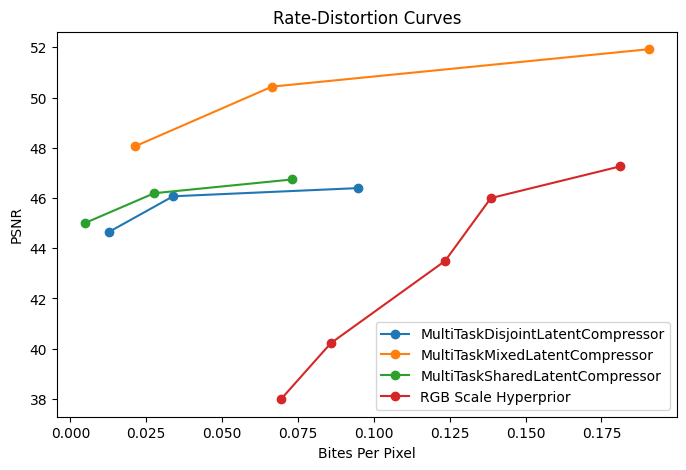

In [266]:
plot_averaged_rate_distortion_curves(per_model_data_dictionary, per_model=True)

## 2. RD Curves across tasks 

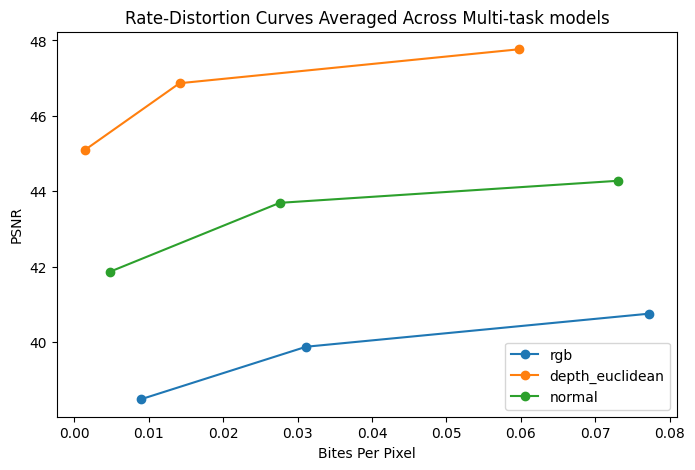

In [222]:
per_task_data_dictionary = {}

for model, task_dict in per_model_data_dictionary.items():
    if model in ("JPEG", "RGB Scale Hyperprior"):
        continue 
        
    for task, values_dict in task_dict.items():
        
        if task not in per_task_data_dictionary.keys():
            per_task_data_dictionary[task] = {}
            
        per_task_data_dictionary[task][model] = per_model_data_dictionary[model][task]
        
plot_averaged_rate_distortion_curves(per_task_data_dictionary, 
                                     per_model=False, 
                                     plot_title="Rate-Distortion Curves Averaged Across Multi-task models")

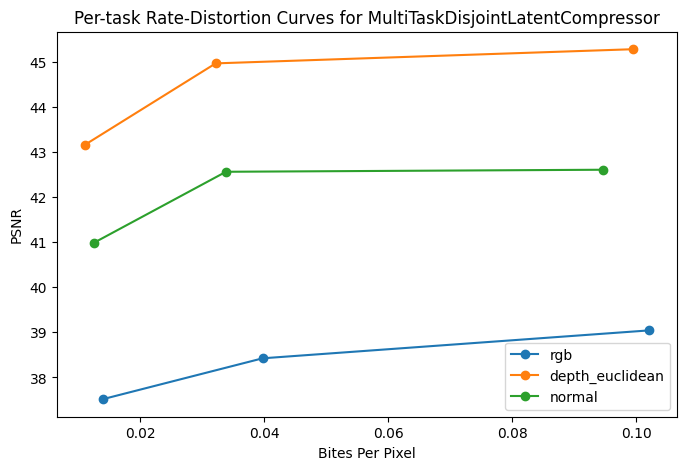

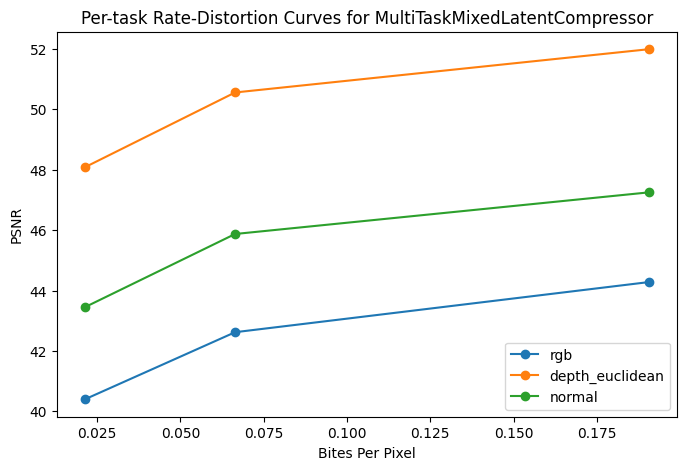

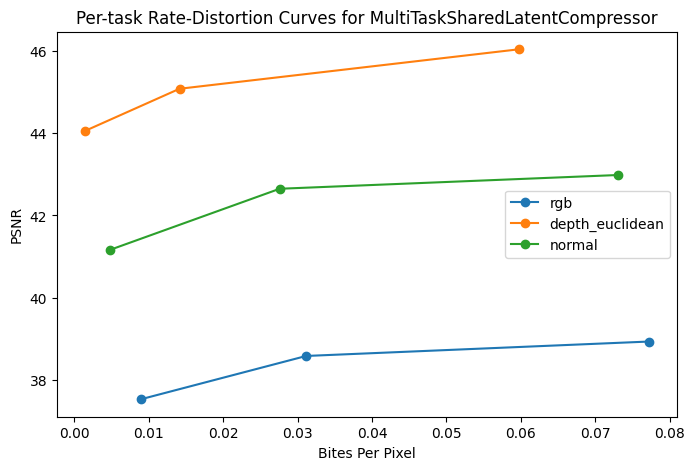

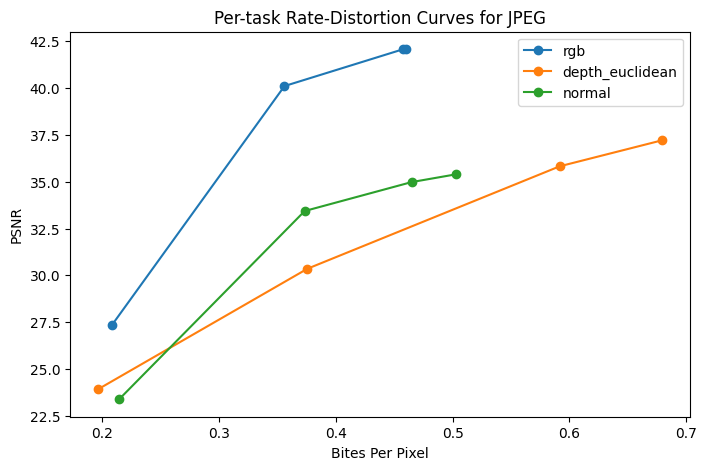

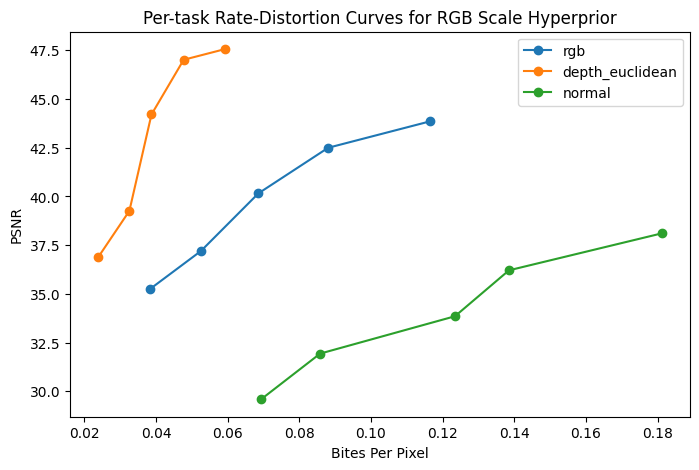

In [227]:
for model in per_model_data_dictionary.keys():
    
    per_task_data_dictionary = {}
    
    for task, values_dict in per_model_data_dictionary[model].items():
        per_task_data_dictionary[task] = {}
        per_task_data_dictionary[task][model] = per_model_data_dictionary[model][task]

    plot_averaged_rate_distortion_curves(per_task_data_dictionary, 
                                         per_model=False,
                                         plot_title=f"Per-task Rate-Distortion Curves for {model}")

---

### Check uncertainty weighting

---

### Let's see how is the memmory disitributed by classes

In [16]:
pl.seed_everything(21)

ckpt_params = torch.load("../model-4-0001.ckpt", map_location="cpu")

# model_type = models.MultiTaskMixedLatentCompressor
model_type = models.MultiTaskSharedLatentCompressor
# model_type = models.MultiTaskDisjointLatentCompressor

compressor = model_type(**ckpt_params["hyper_parameters"]).eval()
compressor.load_state_dict(ckpt_params["state_dict"])
compressor.update_bottleneck_values()

Global seed set to 21


True

In [17]:
compressed_data, bytes, likelihoods = compressor.compress(batch, print_info=True)

Number of actual bytes in a string is: 17612, which gives a BPP = 0.01
Estimated BPP (compression loss) is: 0.01


In [18]:
num_pixels = 256 * 256
y_likelihoods = likelihoods["y"]
z_likelihoods = likelihoods["z"]

channel_bpps = np.array([torch.log(y_likelihoods[:, c]).sum().item() / (-math.log(2) * num_pixels * len(batch["rgb"]))
                for c in range(y_likelihoods.shape[1])])

94% of z's are 1

In [19]:
(z_likelihoods > 0.99).sum()/torch.prod(torch.tensor(z_likelihoods.shape)) * 100

tensor(93.6508)

In [20]:
(y_likelihoods > 0.99).sum()/torch.prod(torch.tensor(y_likelihoods.shape)) * 100

tensor(82.1725)

In [38]:
def plot_by_task(data, taks_borders, plot="scatter"):
    
    n_tasks = len(taks_borders) - 1
    
    task_colors = ["r", "g", "b"]
    legend = ["rgb", "depth", "normals"]
    
    fig, ax = plt.subplots(figsize=(9, 6))
    fig.set_size_inches(5, 4)
        
    
    if n_tasks == 4:
        legend.append("shared")
        task_colors.append("orange")
        
    if plot == "scatter":
        for i in range(n_tasks):
            l = taks_borders[i]
            r = taks_borders[i + 1]

            ax.hlines(data[l: r].mean(), xmin=l, xmax=r, colors=task_colors[i])

            ax.scatter(range(l, r), data[l: r], c=task_colors[i], s=3, label=i)

#         ax.title.set_text('Per-channel bit-rate')
#         ax.set_xlabel('Channel index')
        ax.set_ylabel('BPP')
        
    elif plot == "box":
        ax.boxplot([data[taks_borders[i]: taks_borders[i + 1]] for i in range(n_tasks)])
        ax.set_title('Per-task bit-rate distributions')
        ax.set_xlabel('Task index (rgb, depth, normal)')
        ax.set_ylabel('Task bpp')
        
    elif plot == "bar":
        ax.bar(legend, [sum(data[taks_borders[i]: taks_borders[i + 1]]) for i in range(n_tasks)], color=task_colors)
        ax.set_title('Per-task bit-rate distributions')
        ax.set_xlabel('Task')
        ax.set_ylabel('BPP')
        
#     ax.legend(legend)
    
        
    plt.show()

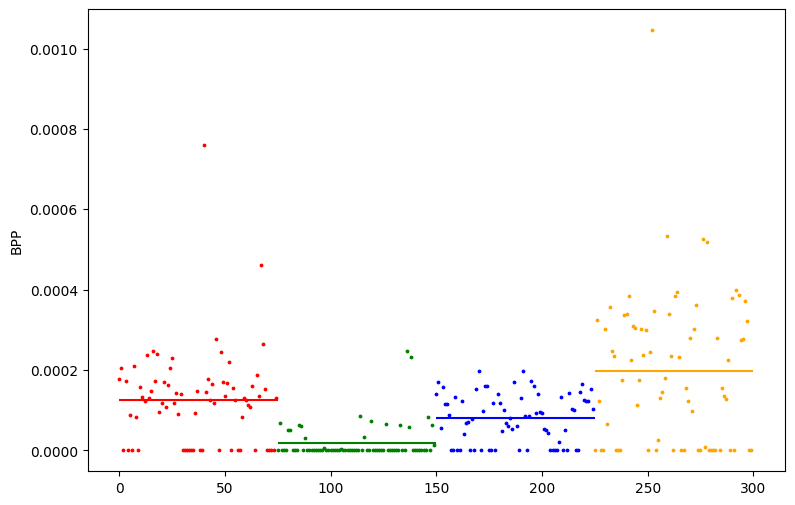

In [22]:
plot_by_task(channel_bpps, task_channels, plot="scatter")

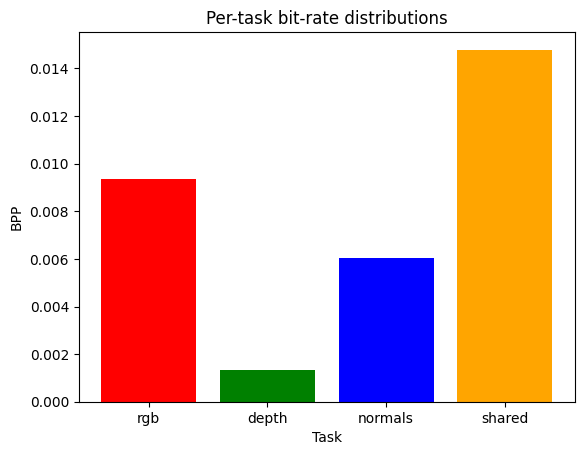

In [23]:
plot_by_task(channel_bpps, task_channels, plot="bar")

## Try to change the shared part to see how the output changes

Here we take two sets of images (2 x 3) and forward them through the encoder part. After that we take **(somehow)** the shared part of one image and concatenate it instead of the shared part of the second set of images and look at the reconstrucitons.

In [9]:
pl.seed_everything(21)

# Load the shared compressor
ckpt_params = torch.load("../model-4-0001.ckpt", map_location="cpu")
model_type = models.MultiTaskSharedLatentCompressor
compressor_shared = model_type(**ckpt_params["hyper_parameters"]).eval()
compressor_shared.load_state_dict(ckpt_params["state_dict"])
compressor_shared.update_bottleneck_values()

# Load the disjoint compressor
ckpt_params = torch.load("../model-3-0001.ckpt", map_location="cpu")
model_type = models.MultiTaskDisjointLatentCompressor
compressor_disjoint = model_type(**ckpt_params["hyper_parameters"]).eval()
compressor_disjoint.load_state_dict(ckpt_params["state_dict"])
compressor_disjoint.update_bottleneck_values()

Global seed set to 21


True

In [11]:
def get_latents(batch, compressor):
    stacked_t = compressor.forward_input_heads(batch)
    compressor_outputs = compressor.model["compressor"](stacked_t)
    
    return compressor_outputs["x_hat"], compressor_outputs["likelihoods"]

In [51]:
input_1 = {task: tensor[6].unsqueeze(0) for task, tensor in batch.items()}
input_2 = {task: tensor[7].unsqueeze(0) for task, tensor in batch.items()}

In [76]:
from copy import deepcopy

latents_1, likelihoods_1 = get_latents(input_1, compressor_shared)
latents_2, likelihoods_2 = get_latents(input_2, compressor_shared)

likelihoods_1 = likelihoods_1["y"]
likelihoods_2 = likelihoods_2["y"]


latents_3 = deepcopy(latents_1.detach())
latents_3[:, -75:] = latents_2[:, -75:]
latents_4 = deepcopy(latents_2.detach())
latents_4[:, -75:] = latents_1[:, -75:]

likelihoods_3 = deepcopy(likelihoods_1.detach())
likelihoods_3[:, -75:] = likelihoods_2[:, -75:]
likelihoods_4 = deepcopy(likelihoods_2.detach())
likelihoods_4[:, -75:] = likelihoods_1[:, -75:]

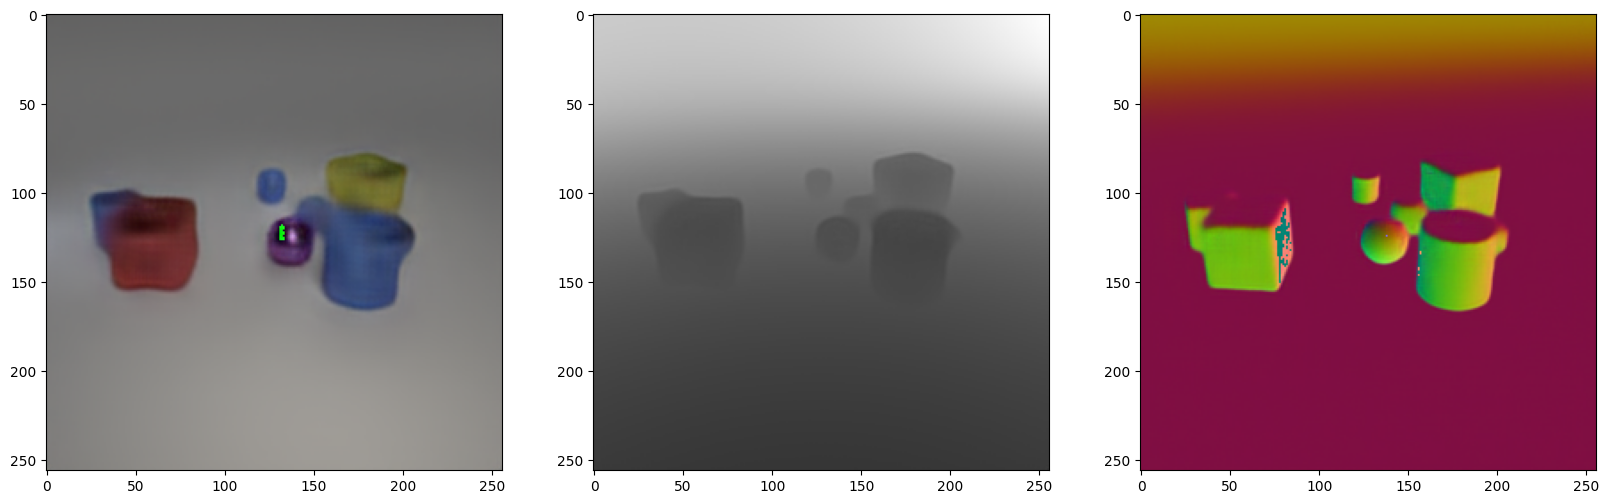

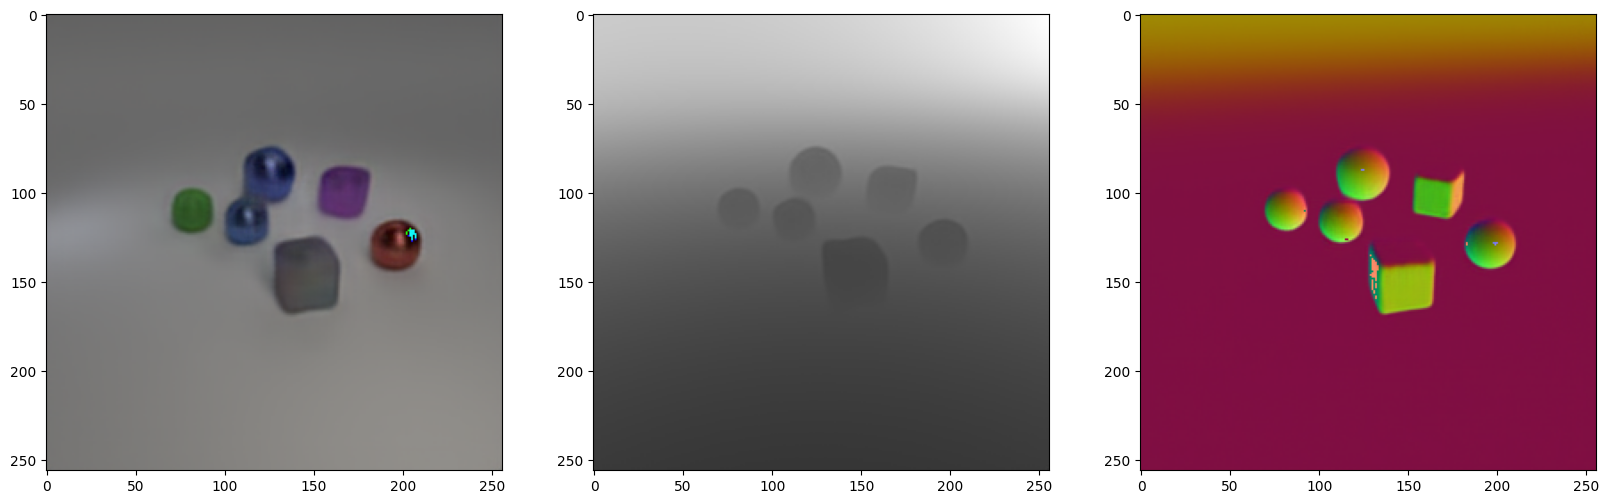

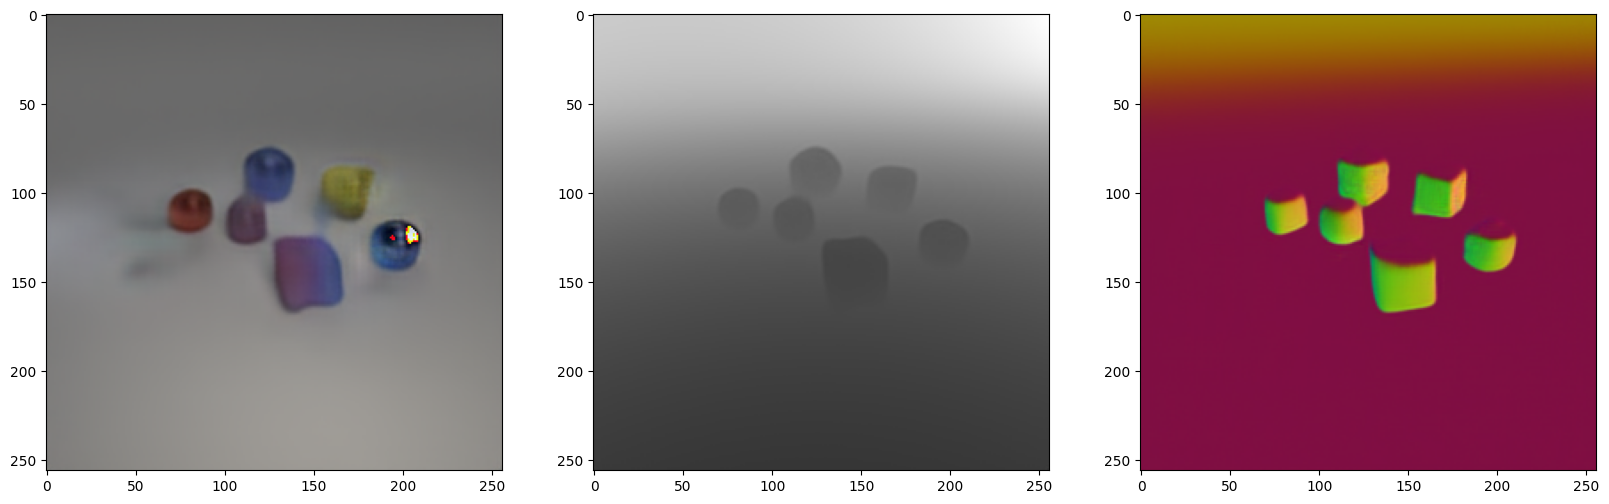

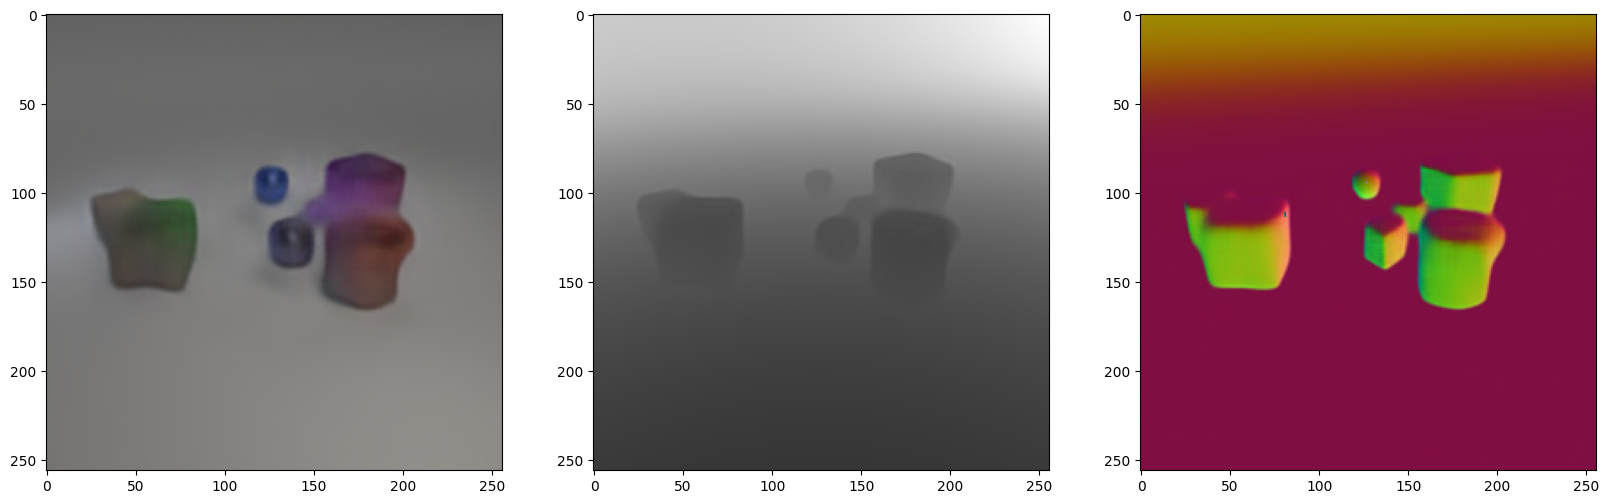

In [77]:
for lat in (latents_1, latents_2, latents_3, latents_4):
    images = [compressor_shared.forward_output_heads(lat)[task].squeeze().cpu() for task in batch.keys()]
    images[1] = (images[1]/images[1].max()).repeat(3, 1, 1)

    utils.show_images([transforms.ToPILImage()(im) for im in images])

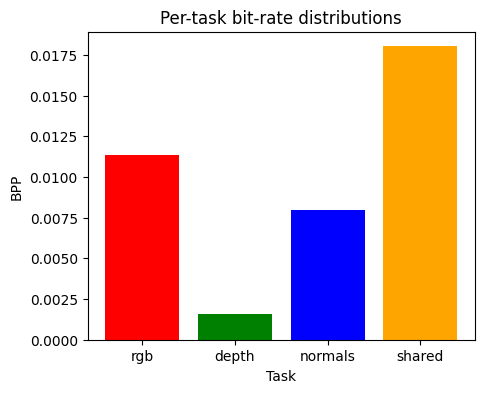

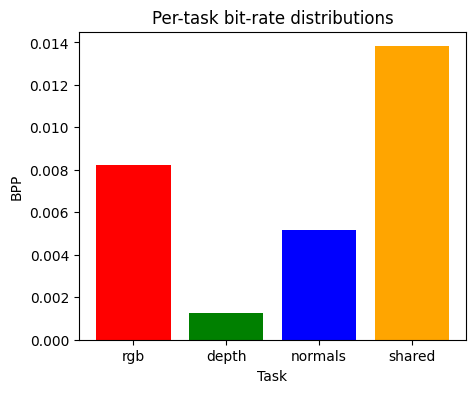

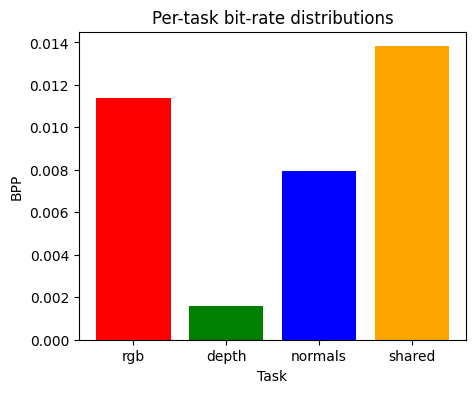

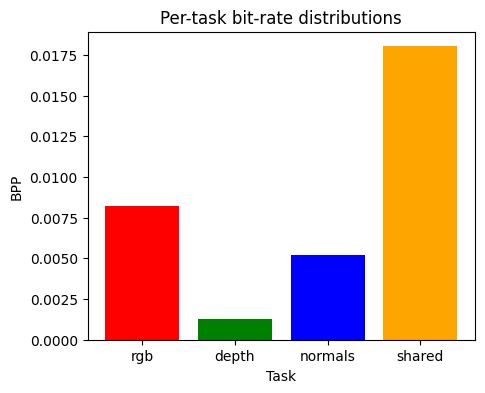

In [78]:
for like in (likelihoods_1, likelihoods_2, likelihoods_3, likelihoods_4):
    plot_by_task(compute_bpp(like.detach(), NUM_PIXELS), TASK_CHANNELS["shared"], plot="bar")

Same samples but for the disjoint model

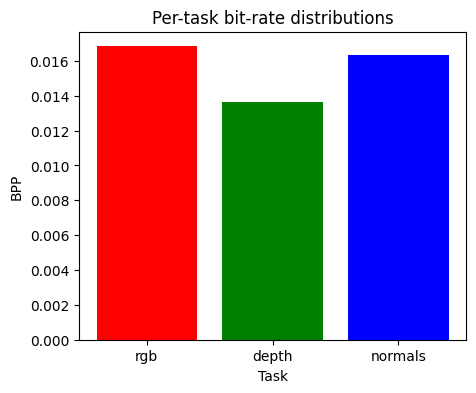

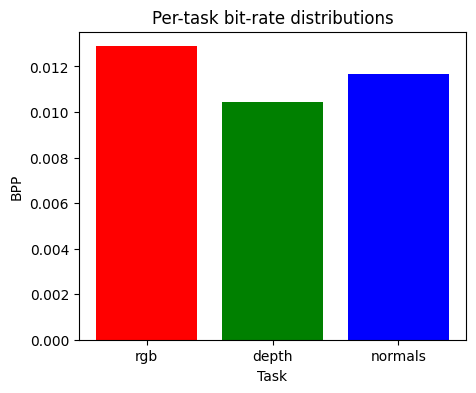

In [59]:
_, likelihoods_disj_1 = get_latents(input_1, compressor_disjoint)
_, likelihoods_disj_2 = get_latents(input_2, compressor_disjoint)

for like in (likelihoods_disj_1, likelihoods_disj_2):
    plot_by_task(compute_bpp(like["y"].detach(), NUM_PIXELS), TASK_CHANNELS["disjoint"], plot="bar")

### Now we will pass the reconstructions of swaped images through the disjoint latent.

To see how the distribution of bits per pixel changed and potentially see where did the "shared" latent part go.

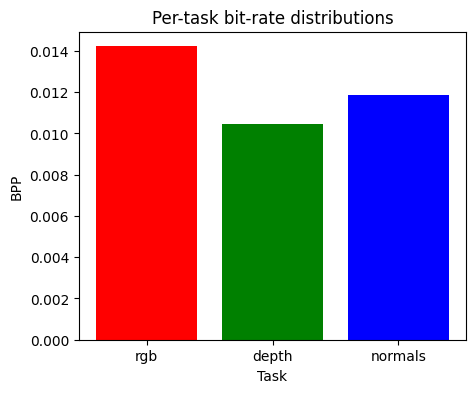

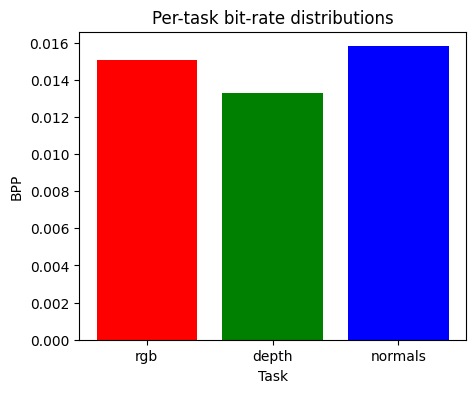

In [81]:
for lat in (latents_3, latents_4):
    images = {task: compressor_shared.forward_output_heads(lat)[task].cpu() for task in batch.keys()}
    
    _, l_ = get_latents(images, compressor_disjoint)
#     images[1] = (images[1]/images[1].max()).repeat(3, 1, 1)

    plot_by_task(compute_bpp(l_["y"].detach(), NUM_PIXELS), TASK_CHANNELS["disjoint"], plot="bar")

### What if we now use a shared part that is averaged across a batch?

In [66]:
batch_latents, batch_likelihoods = get_latents(batch, compressor_shared)
batch_latents.shape

torch.Size([64, 300, 4, 4])

In [74]:
latents_5 = deepcopy(latents_1.detach())
latents_5[:, -75:] = batch_latents.mean(dim=0)[-75:]

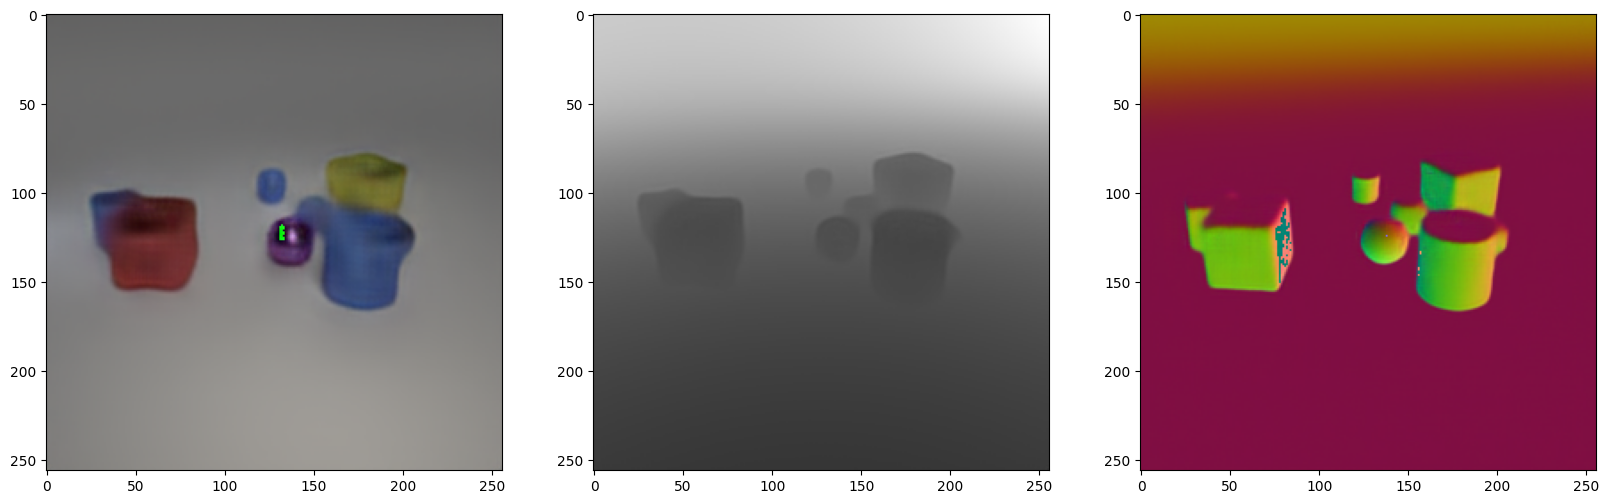

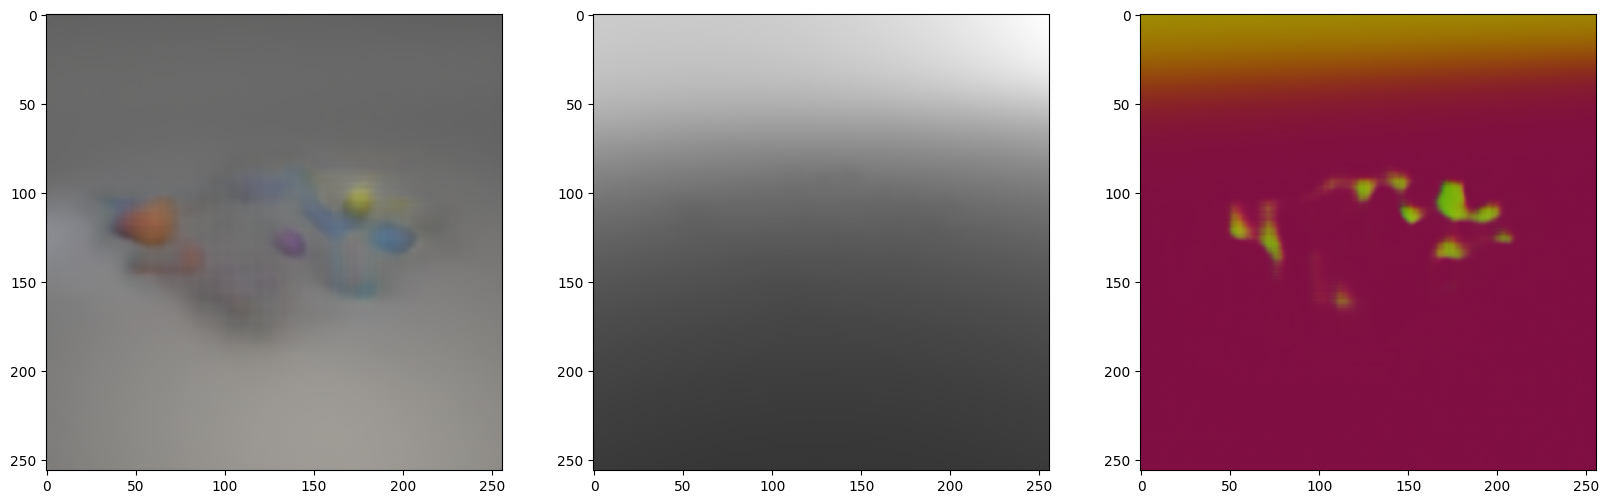

In [75]:
for lat in (latents_1, latents_5):
    images = [compressor_shared.forward_output_heads(lat)[task].squeeze().cpu() for task in batch.keys()]
    images[1] = (images[1]/images[1].max()).repeat(3, 1, 1)

    utils.show_images([transforms.ToPILImage()(im) for im in images])

### Now we will pass the reconstructions with an averaged latent through the disjoint latent.

To see how the distribution of bits per pixel changed and potentially see where did the "shared" latent part go.

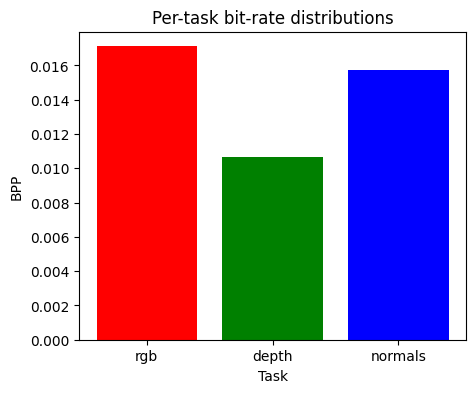

In [85]:
for lat in (latents_5,):
    images = {task: compressor_shared.forward_output_heads(lat)[task].cpu() for task in batch.keys()}
    
    _, l_ = get_latents(images, compressor_disjoint)
#     images[1] = (images[1]/images[1].max()).repeat(3, 1, 1)

    plot_by_task(compute_bpp(l_["y"].detach(), NUM_PIXELS), TASK_CHANNELS["disjoint"], plot="bar")